# Universidad de Buenos Aires
# Deep Learning - TP1
# Mayo 2024

El TP comienza al momento de recibir este correo y la ventana de entrega estará abierta hasta el Domingo 16 de Junio. La resolución es individual. Pueden utilizar los contenidos vistos en clase y otra bibliografía. Si se toman ideas de fuentes externas deben ser correctamente citas incluyendo el correspondiente link o página de libro.

El formato de entrega debe ser un “link a un colab” (compartir a las siguientes direcciones: maxit1992@gmail.com, alfonsorafel93@gmail.com y lelectronfou@gmail.com). Tanto los resultados, como el código y las explicaciones deben quedar guardados y visualizables en el colab. El colab debe poder ser ejecutado sin errores.



## Ejercicio 1

**Dado el grafo de cómputo de la imagen siguiente, donde a=1, b=2 y c=3:**

1. Realizar el paso forward y calcular Y.

2. Realizar el paso backward y calcular el backpropagation para a,b y c:

    a. En forma analítica (dy/dx = 0)

    b. Utilizando pytorch

    c. Comparar los resultados de los puntos anteriores

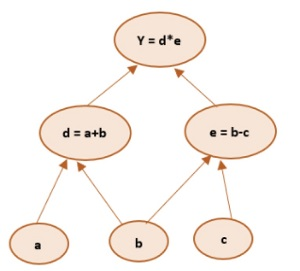

### Solucion ejercicio 1


**Paso forward**  
$$
\begin{gathered}
d=a+b\\
d=1+2\\
d=3\\
\\
e=b-c\\
e=2-3\\
e=-1\\
\\
Y=d \cdot e\\
Y=3 \cdot (-1)\\
Y=-3\\
\end{gathered}
$$

**Paso backward - Forma analitica**
  
Primero calculamos las derivadas parciales con respecto a *a*, *b* y *c*. Para esto tambien necesitamos calcular las derivadas parciales con respecto a *d* y *e*.

$$
\begin{gathered}
\frac{\partial Y}{\partial e} = \frac{\partial {(d \cdot e)}}{\partial e}\\
\frac{\partial Y}{\partial e} = d\\
\frac{\partial Y}{\partial e} = 3\\
\\
\frac{\partial Y}{\partial d} = \frac{\partial {(d \cdot e)}}{\partial d}\\
\frac{\partial Y}{\partial d} = e\\
\frac{\partial Y}{\partial d} = -1\\
\\
\frac{\partial e}{\partial c} = \frac{\partial {(b-c)}}{\partial c}\\
\frac{\partial e}{\partial c} = -1\\
\\
\frac{\partial e}{\partial b} = \frac{\partial {(b-c)}}{\partial c}\\
\frac{\partial e}{\partial b} = 1\\
\\
\frac{\partial d}{\partial b} = \frac{\partial {(a+b)}}{\partial c}\\
\frac{\partial d}{\partial b} = 1\\
\\
\frac{\partial d}{\partial a} = \frac{\partial {(a+b)}}{\partial c}\\
\frac{\partial d}{\partial a} = 1\\
\end{gathered}
$$

Por regla de la cadena, podemos calcular las derivadas parciales de *Y* con respecto a *a*, *b* y *c*.

$$
\begin{gathered}
\frac{\partial Y}{\partial c} = \frac{\partial Y}{\partial e} \cdot \frac{\partial e}{\partial c}\\
\frac{\partial Y}{\partial c} = 3 \cdot (-1)\\
\frac{\partial Y}{\partial c} = -3\\
\\
\frac{\partial Y}{\partial b} = \frac{\partial Y}{\partial d} \cdot \frac{\partial d}{\partial b} + \frac{\partial Y}{\partial e} \cdot \frac{\partial e}{\partial b}\\
\frac{\partial Y}{\partial b} = (-1) \cdot 1 + 3 \cdot 1\\
\frac{\partial Y}{\partial b} = 2\\
\\
\frac{\partial Y}{\partial a} = \frac{\partial Y}{\partial d} \cdot \frac{\partial d}{\partial a}\\
\frac{\partial Y}{\partial a} = (-1) \cdot 1\\
\frac{\partial Y}{\partial a} = -1\\
\end{gathered}
$$

**Paso backward - Pytorch**

In [1]:
import torch

In [2]:
a = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(2.0, requires_grad=True)
c = torch.tensor(3.0, requires_grad=True)

# Paso forward
d = a + b
e = b - c
Y = d * e

# Paso backward
Y.backward()

# Resultados
print(f'dY/da: {a.grad}')
print(f'dY/db: {b.grad}')
print(f'dY/dc: {c.grad}')


dY/da: -1.0
dY/db: 2.0
dY/dc: -3.0


## Ejercicio 2

Se desea construir un sistema de recomendación de películas. Para esto se cuenta con un dataset de las puntuaciones que los usuarios han asignado a las peliculas disponibles.

Link dataset: https://drive.google.com/file/d/1Og9H-8oqb3_Wo_WOakeAuRR_mwr922Ar/view?usp=sharing

Para verificar la factibilidad del proyecto con datos válidos, se decide utilizar solamente las 200 películas con más votos y los usuarios que han puntuado al menos 100 películas.

1- Analizar el dataset para utilizar solamente las 200 películas con mayor cantidad de votos y los usuarios que hayan votado al menos 100 películas.

2- A partir del dataset del punto 1, construir una única red neuronal que utilice una capa de embeddings para el id de usuario, una capa de embeddings para el id de película y al menos dos capas lineales que sea capaz de predecir el puntaje que cada usuario colocó a cada pelicula.

3- Elegir un usuario al azar, una película que dicho usuario haya puntuado y verificar la predicción del modelo. Comparar con el puntaje real que el usuario asignó a dicha película.

4- Realizar una recomendación de película para el usuario del punto 3 utilizando los embeddings de usuario o los embeddings de películas. Comprobar si la recomendación es correcta haciendo una predicción del puntuaje con la red neuronal.

### Solucion ejercicio 2


#### Parte 1

Comenzamos por importar librerias y cargar el dataset.

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

df = pd.read_csv('https://drive.google.com/uc?id=1Og9H-8oqb3_Wo_WOakeAuRR_mwr922Ar')



Reducimos el tamaño y aumentamos la confiabilidad del dataset, segun los parametros especificados:
 - Utilizar solamente las 200 peliculas que mas votos tienen
 - Utilizar solamente los usuarios que han puntuado al menos 100 peliculas

Adicionalmente vamos a remover la columna timestamp que no aporta al modelo.

In [8]:
# Remover columna timestamp
df = df.drop(['timestamp'], axis = 1)

# Filtrar usuarios que han puntuado al menos 100 peliculas
user_rating_counts = df.groupby('userId').size()
users_with_100_ratings = user_rating_counts[user_rating_counts >= 100].index
df = df[df['userId'].isin(users_with_100_ratings)]

# Filtrar las 200 peliculas con mas votos
movie_rating_counts = df.groupby('movieId').size()
top_200_movies = movie_rating_counts.nlargest(200).index
df = df[df['movieId'].isin(top_200_movies)]

#### Parte 2

Construimos un modelo con las siguientes caracteristicas:
 - El embedding de usuarios será de 5 parametros.
 - El embedding de peliculas será de 15 parametros.
 - La primera capa de embeddings es de 20 (15+5) neuronas con salida ReLU.
 - La segunda capa es de 100 neuronas con salida ReLU.
 - La tercera capa es de 50 neuronas.

In [9]:
class MovieRatingPredictor(nn.Module):
    def __init__(self, num_users, num_movies, user_embedding_dim=10, movie_embedding_dim=15, hidden_dim=100):
        super(MovieRatingPredictor, self).__init__()
        self.user_embedding = nn.Embedding(num_users, user_embedding_dim)
        self.movie_embedding = nn.Embedding(num_movies, movie_embedding_dim)
        self.fc1 = nn.Linear(user_embedding_dim + movie_embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, 1)

    def forward(self, user_id, movie_id):
        user_embedded = self.user_embedding(user_id)
        movie_embedded = self.movie_embedding(movie_id)
        x = torch.cat([user_embedded, movie_embedded], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Necesitamos modificar los usuarios y peliculas, ya que los embeddings esperan que los valores vayan desde [0, embeddings - 1], pero hay usuarios y peliculas con IDs fuera de esos valores.

In [10]:
unique_users = df['userId'].unique()
unique_movies = df['movieId'].unique()
print('Unique users: \n')
print(unique_users)
print('Unique movies: \n')
print(unique_movies)

Unique users: 

[  1   4   6   7  10  15  17  18  19  20  21  22  23  24  27  28  32  33
  39  40  41  42  43  45  47  50  51  52  57  58  59  62  63  64  66  68
  73  74  76  80  82  83  84  89  91  95 100 103 104 105 109 111 113 115
 117 119 122 125 129 132 135 136 137 139 140 141 144 153 156 160 166 167
 169 177 181 182 184 186 187 195 198 199 200 201 202 210 212 216 217 219
 220 221 222 226 230 232 233 234 239 240 246 247 249 254 256 260 263 265
 266 268 274 275 279 280 282 286 287 288 290 292 294 298 301 304 305 306
 307 308 309 312 313 314 317 318 322 325 326 328 330 331 332 334 339 346
 351 352 354 356 357 362 365 367 368 369 372 373 376 377 380 381 382 385
 387 391 393 405 408 409 410 411 412 414 419 420 424 425 428 432 434 436
 437 438 448 452 453 462 464 465 466 469 474 475 477 479 480 482 483 484
 488 489 490 492 495 509 510 514 517 520 522 524 525 527 534 542 551 552
 555 559 560 561 562 563 564 567 570 571 572 573 577 580 586 587 590 593
 594 596 597 599 600 601 602 603 60

Para eso entonces tenemos que mapear los valores reindexados a los valores originales y viceversa.

In [11]:
# Guardar los IDs originales
original_user_ids = df['userId'].unique()
original_movie_ids = df['movieId'].unique()

# Reindexar userId y movieId para que comiencen desde 0
df['userId'] = df['userId'].astype('category').cat.codes
df['movieId'] = df['movieId'].astype('category').cat.codes

# Mapear los IDs reindexados a los originales
user_id_map = {index: original_id for index, original_id in enumerate(original_user_ids)}
movie_id_map = {index: original_id for index, original_id in enumerate(original_movie_ids)}

Ya teniendo los mapas, podemos crear el modelo, convertir los datos a tensores PyTorch y crear el DataLoader.

In [12]:
# Crear el modelo
model = MovieRatingPredictor(len(unique_users), len(unique_movies))

# Convertir los datos a tensores
user_ids = torch.tensor(df['userId'].values, dtype=torch.long)
movie_ids = torch.tensor(df['movieId'].values, dtype=torch.long)
ratings = torch.tensor(df['rating'].values, dtype=torch.float32)

# Crear el TensorDataset y DataLoader
dataset = TensorDataset(user_ids, movie_ids, ratings)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

Finalizando el proceso del modelo, cerramos con su entrenamiento. Definimos una funcion de perdida (MSE), un optimizador (ADAM) y una cantidad de epocas para entrenarlo (300).

In [13]:
# Definir el optimizador y la función de perdida
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Guardar la perdida del modelo en una variable
global_loss = []

# Entrenar el modelo
num_epochs = 500

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for user_id, movie_id, rating in dataloader:
        optimizer.zero_grad()
        outputs = model(user_id, movie_id).squeeze()
        loss = criterion(outputs, rating)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader)}')
    global_loss.append(running_loss/len(dataloader))

Epoch 1/500, Loss: 1.8425168710239863
Epoch 2/500, Loss: 0.875689662108987
Epoch 3/500, Loss: 0.7940613374871722
Epoch 4/500, Loss: 0.7481259893562834
Epoch 5/500, Loss: 0.712021786883726
Epoch 6/500, Loss: 0.6848117758662013
Epoch 7/500, Loss: 0.6654646283489163
Epoch 8/500, Loss: 0.6528020666817488
Epoch 9/500, Loss: 0.6427827750222158
Epoch 10/500, Loss: 0.6355729214215683
Epoch 11/500, Loss: 0.628615668264486
Epoch 12/500, Loss: 0.6228594147552878
Epoch 13/500, Loss: 0.6181453850309727
Epoch 14/500, Loss: 0.6138274007934635
Epoch 15/500, Loss: 0.6069980278863745
Epoch 16/500, Loss: 0.600408772391788
Epoch 17/500, Loss: 0.5950493228637566
Epoch 18/500, Loss: 0.5891533705137544
Epoch 19/500, Loss: 0.5840284123259075
Epoch 20/500, Loss: 0.5790218139098863
Epoch 21/500, Loss: 0.5704555915573896
Epoch 22/500, Loss: 0.5621944973024271
Epoch 23/500, Loss: 0.5568932755518767
Epoch 24/500, Loss: 0.5512720926838406
Epoch 25/500, Loss: 0.5452550600140782
Epoch 26/500, Loss: 0.5377814626289626

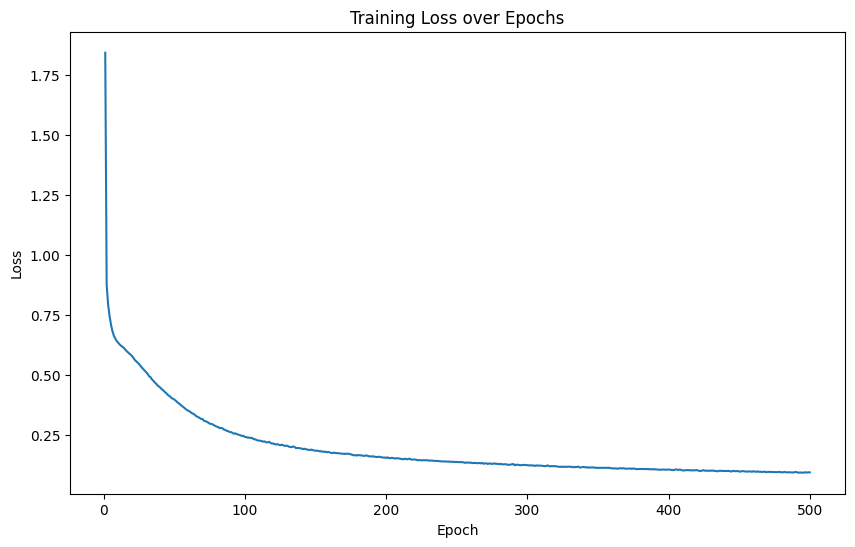

In [14]:
# Graficar la pérdida a lo largo de las epochs
plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, num_epochs + 1), y=global_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

#### Parte 3

Con el modelo ya entrenado, es facil realizar predicciones (recomendaciones) a un usuario: se selecciona un usuario al azar y una pelicula que ese usuario haya puntuado (para poder comparar la prediccion con la realidad).

In [15]:
# Elegir un usuario al azar
random_user_id = random.choice(df['userId'].unique())

# Filtrar las películas puntuadas por el usuario seleccionado
user_movies = df[df['userId'] == random_user_id]

# Elegir una película al azar que haya sido puntuada por el usuario
random_movie_row = user_movies.sample(n=1).iloc[0]
random_movie_id = random_movie_row['movieId']
actual_rating = random_movie_row['rating']

print(f"Usuario ID: {user_id_map[random_user_id]}")
print(f"Película ID: {movie_id_map[random_movie_id]}")
print(f"Rating real: {actual_rating}\n")

# Convertir los IDs seleccionados a tensores
random_user_tensor = torch.tensor([random_user_id], dtype=torch.long)
random_movie_tensor = torch.tensor([random_movie_id], dtype=torch.long)

# Poner el modelo en modo de evaluación
model.eval()

# Hacer la predicción
with torch.no_grad():
    predicted_rating = model(random_user_tensor, random_movie_tensor).item()

# El modelo puede predecir valores por encima de 5 (que es el maximo), por lo que hay que clampearlo
print(f"Rating predicho: {predicted_rating if predicted_rating < 5 else 5:.1f}")

Usuario ID: 113
Película ID: 648
Rating real: 4.0

Rating predicho: 3.9


#### Parte 4

Para hacer una predicción, disponemos de dos opciones:

1. Buscar un usuario similar al seleccionado, y recomendarle la película mejor puntuada de ese usuario.
2. Buscar una película similar a las mejores puntuadas por el usuario seleccionado y recomendarla.

Ambos metodos requieren que se busque similitud entre embeddings: en la primera opción buscamos embeddings de usuarios similares y en la segunda opción buscamos embeddings de películas similares. El metodo que utilizaré para medir esta similitud es la similitud del coseno (https://es.wikipedia.org/wiki/Similitud_coseno), el cual estó implementado en pytorch (https://pytorch.org/docs/stable/generated/torch.nn.CosineSimilarity.html).

##### Metodo 1 de recomendación: por embedding de usuario

In [81]:
# Obtener el embedding del usuario seleccionado al azar y los embeddings de todos los usuarios
user_embeddings = model.user_embedding.weight.data
random_user_embedding = model.user_embedding.weight.data[random_user_id]

# Calcular la similitud coseno entre el embedding del usuario seleccionado y todos los embeddings de usuarios
cosine_similarity = nn.CosineSimilarity()
similarities = cosine_similarity(user_embeddings, random_user_embedding)

# Establecer la similitud del usuario consigo mismo a -1 para evitar auto-recomendación
similarities[random_user_id] = -1

# Encontrar el índice del usuario más similar
most_similar_user = similarities.argmax().item()
print(f'El usuario mas similar al usuario {user_id_map[random_user_id]} es el usuario {user_id_map[most_similar_user]} (similitud de {100 * similarities[most_similar_user]:.2f}%).')

El usuario mas similar al usuario 113 es el usuario 306 (similitud de 83.39%).


In [165]:
# Encontrar las peliculas evaluadas por el usuario mas similar
most_similar_user_rated_movies = df[df['userId'] == most_similar_user]
most_similar_user_top_5_rated_movies = most_similar_user_rated_movies.sort_values(by='rating', ascending=False).head(5)
most_similar_user_top_5_rated_movies = most_similar_user_top_5_rated_movies.reset_index(drop=True)

most_similar_user_top_5_rated_movies['movieId'] = most_similar_user_top_5_rated_movies['movieId'].apply(lambda x: movie_id_map[x])

#print(f'Basandonos en el usuario mas similar, se recomienda que la persona vea la pelicula {most_similar_user_top_5_rated_movies['movieId'][0]}.')
#print(f'En caso de ya haberla visto, puede ver {most_similar_user_top_5_rated_movies[1]}, \
#      {most_similar_user_top_5_rated_movies[2]}, \
#      {most_similar_user_top_5_rated_movies[3]} o \
#      {most_similar_user_top_5_rated_movies[4]}.')

In [167]:
most_similar_user_top_5_rated_movies['movieId'][0]

4878